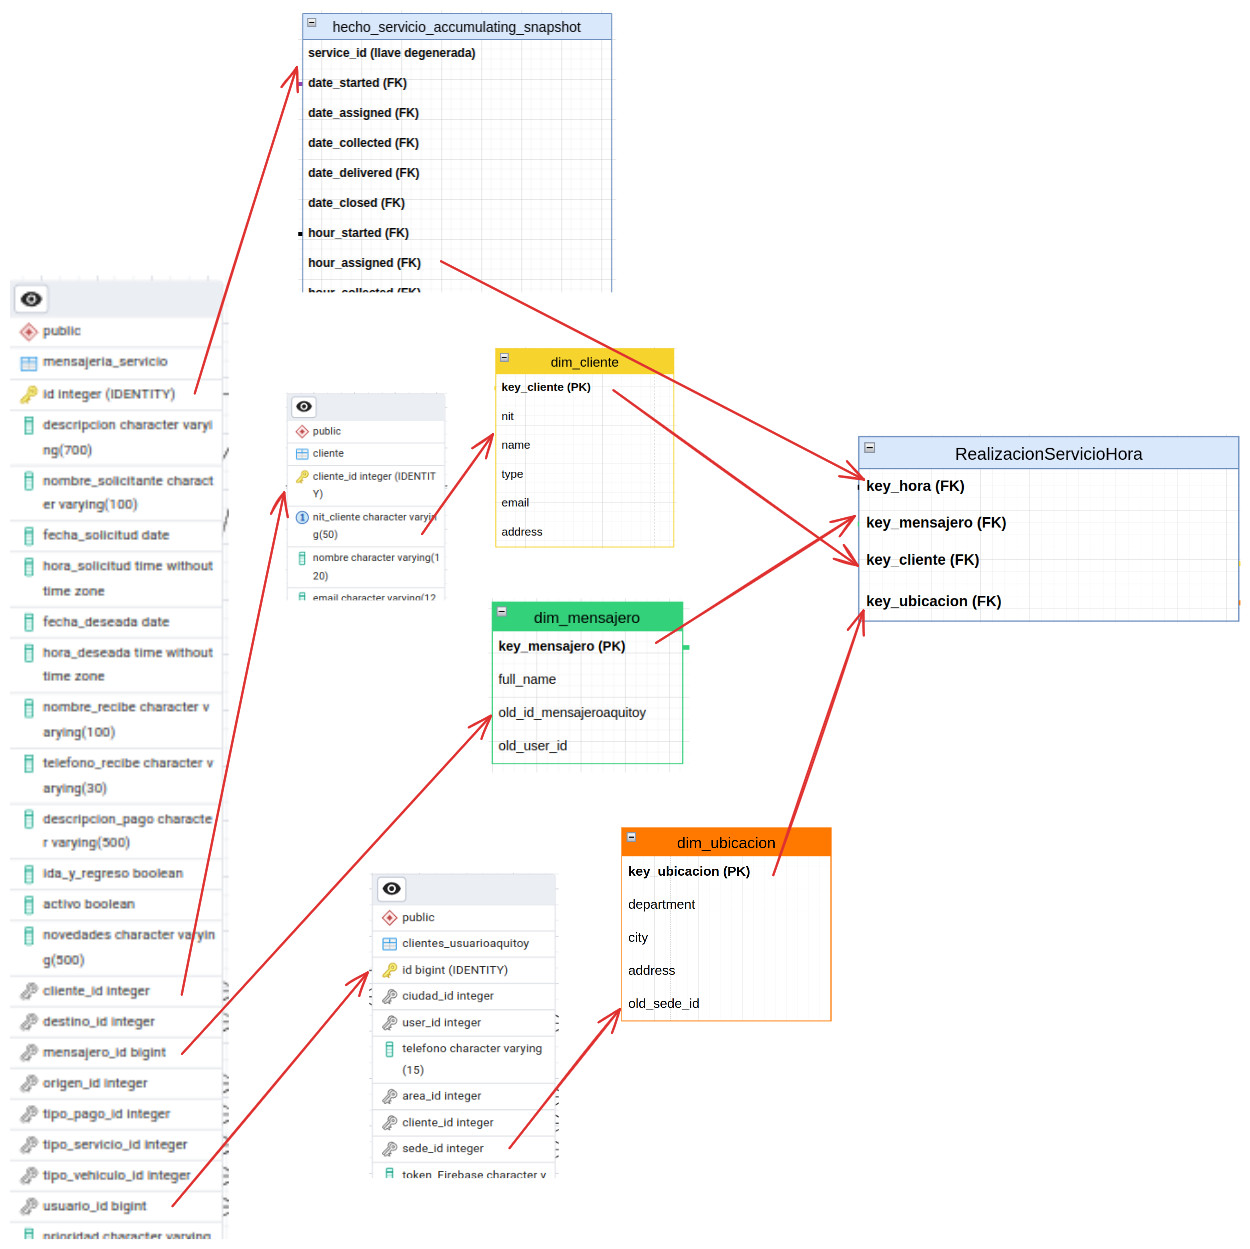

## Importar librerías

In [ ]:
import pandas as pd
import sqlalchemy as sa
import utils.conn_tools as ct

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

### Asimilación de dimensiones

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

## Extract

In [ ]:
# Leer los datos de las tablas

# De la fuente
msj_servicio = pd.read_sql_table("mensajeria_servicio", con=engine_src)
#cliente = pd.read_sql_table("cliente", con=engine_src)
#cliente_usuario = pd.read_sql_table("clientes_usuarioaquitoy", con=engine_src)

# Del Warehouse
#dim_cliente = pd.read_sql_table("dim_cliente", con=engine_etl)
#dim_mensajero = pd.read_sql_table("dim_mensajero", con=engine_etl)
#dim_ubicacion = pd.read_sql_table("dim_ubicacion", con=engine_etl)
hecho_servicio_accumulating_snapshot = pd.read_sql_table(
    "hecho_servicio_accumulating_snapshot", con=engine_etl
)

## Transform

In [ ]:
# Crear DataFrame con los datos de servicios (solo necesarios)
merged_df = pd.DataFrame(
    {
        "servicio_id": msj_servicio["id"],
        #"cliente_id": msj_servicio["cliente_id"],
        #"mensajero_id": msj_servicio["mensajero_id"],
        #"usuario_id": msj_servicio["usuario_id"],
    }
)

# Combinar con dim_hora para obtener las horas
merged_df = merged_df.merge(
    hecho_servicio_accumulating_snapshot,
    left_on="servicio_id",
    right_on="service_id",
    suffixes=("_mdf", "_hecho"),
)

# Limpiar para quedarse unicamente con la hora deseada
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["time_assigned"],
        #"cliente_id": merged_df["cliente_id"],
        #"mensajero_id": merged_df["mensajero_id"],
        #"usuario_id": merged_df["usuario_id"],
    }
)

merged_df.head(3)

In [ ]:
# Asegurarse de que ambas columnas sean del mismo tipo
'''merged_df["mensajero_id"] = merged_df["mensajero_id"].astype("Int64")
dim_mensajero["old_id_mensajeroaquitoy"] = dim_mensajero[
    "old_id_mensajeroaquitoy"
].astype("Int64")
'''
# Verificar si el mensajero_id 7 está presente en old_id_mensajeroaquitoy
# Esta es una verificacion importante porque user_id = 7 no existe en dim_mensajero
# Si no existe, old_id_mensajeroaquitoy esta mal asignada en la dimension
'''mensajero_7_en_dim = dim_mensajero[dim_mensajero["old_id_mensajeroaquitoy"] == 7]
print(f"Mensajero con ID 7 en dim_mensajero:\nrow {mensajero_7_en_dim}")'''


# Realizar la combinación utilizando "left" para no perder filas
'''merged_df = merged_df.merge(
    dim_mensajero,
    left_on="mensajero_id",
    right_on="old_id_mensajeroaquitoy",
    how="left",  # "left" asegura que todas las filas de merged_df se conserven
    suffixes=("_mdf", "_dimmens"),
)'''

# Verificar si hay valores nulos en las columnas después de la combinación
'''print(
    f"Filas sin coincidencias: {merged_df[merged_df['key_mensajero'].isna()].shape[0]}"
)

# Verificar cuántos valores únicos de mensajero_id y key_mensajero hay
print(f"Número de mensajero_id únicos: {merged_df['mensajero_id'].nunique()}")
print(f"Número de key_mensajero únicos: {merged_df['key_mensajero'].nunique()}")'''


# Limpiar para quedarse unicamente con la key_mensajero
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["key_hora"],
        #"key_mensajero": merged_df["key_mensajero"],
        #"cliente_id": merged_df["cliente_id"],
        #"mensajero_id": merged_df["mensajero_id"],
        #"usuario_id": merged_df["usuario_id"],
    }
)

print(f"Cantidad de filas después de la limpieza: {merged_df.shape[0]}")
merged_df.head(10)

In [ ]:
'''
# Combinar con cliente para ver el nit_cliente
merged_df = merged_df.merge(
    #cliente,
    left_on="cliente_id",
    right_on="cliente_id",
    suffixes=("_mdf", "_dimcli"),
)

# Combinar con dim_cliente usando el nit_cliente - nit
merged_df = merged_df.merge(
    #dim_cliente,
    left_on="nit_cliente",
    right_on="nit",
    suffixes=("_mdf", "_dimcli"),
)
'''
# Limpiar para quedarse unicamente con el key_cliente
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["key_hora"],
        #"key_mensajero": merged_df["key_mensajero"],
        #"key_cliente": merged_df["key_cliente"],
        #"usuario_id": merged_df["usuario_id"],
    }
)

print(f"Cantidad de filas después de la limpieza: {merged_df.shape[0]}")
merged_df.head(3)

In [ ]:
'''
# Combinar con `cliente_usuario` para obtener sede de cliente
merged_df = merged_df.merge(
    #cliente_usuario,
    left_on="usuario_id",
    right_on="id",
    suffixes=("_mdf", "_clieusr"),
)

# Combinar con `dim_ubicacion_unique` para incluir solo la primera ocurrencia de cada dirección
merged_df = merged_df.merge(
    dim_ubicacion,
    left_on="sede_id",
    right_on="old_sede_id",
    suffixes=("_mdf", "_dimubi"),
)
'''
# Extraer solo datos necesarios
merged_df = pd.DataFrame(
    {
        "key_hora": merged_df["key_hora"],
        #"key_mensajero": merged_df["key_mensajero"],
        #"key_cliente": merged_df["key_cliente"],
        #"key_ubicacion": merged_df["key_ubicacion"],
    }
)

print(merged_df.count())
merged_df.head(3)

In [ ]:
# Group
merged_df = merged_df.groupby(
    ["key_hora"]
).size().reset_index(name="total_at_hour")

## Load: Ejecución de ETL

In [ ]:
hecho_realizacion_servicio_hora_table = sa.Table(
    "hecho_realizacion_servicio_hora",
    metadata,
    # Primary key
    sa.Column(
        "key_hecho_realizacion_servicio_hora",
        sa.Integer,
        primary_key=True,
        autoincrement=True,
    ),
    # Dimension keys
    sa.Column("key_hora", sa.Integer, sa.ForeignKey("dim_hora.key_hora")),
    #sa.Column("key_mensajero", sa.Integer, sa.ForeignKey("dim_mensajero.key_mensajero")),
    #sa.Column("key_cliente", sa.Integer, sa.ForeignKey("dim_cliente.key_cliente")),
    #sa.Column("key_ubicacion", sa.Integer, sa.ForeignKey("dim_ubicacion.key_ubicacion")),
    sa.Column("total_at_hour", sa.Integer),
)

metadata.create_all(engine_etl)

In [ ]:
merged_df.to_sql(
    name="hecho_realizacion_servicio_hora",
    con=engine_etl,
    if_exists="append",
    index=False,
)